In [1]:
%autosave 0

Autosave disabled


In [2]:
import os
startup_file = "/Users/octavia/Dropbox/fire/src_v1/startup.py"

In [3]:
run "/Users/octavia/Dropbox/fire/src_v1/startup.py"

###  Maximum severity / minimm return interval to sustain upper canopy biomass

In [4]:
params =  {
    "alpha" : 0.04,
    "beta" : 0.5,
    "k_u" : 20.,
    "k_l" : 5.,    
    "r_u" : 0.25,
    "r_l" : 1.5,                    
    "S" : 0.5,
    "dt" : 0.01,
    "dt_p" : 0.1,            
    "seed" : 0,
    "ti" : 1000,        
    "tmax" : 3000,      
    "RI" : 20,
    "ignition_type" : "fixed",   
    "chi" : 1,                           
    "severity_type" : "fixed",
    "severity" : 0.7,
    "std_severity" : 0.1,
    "r" : 0.5, 
    "a" : 0.01,
    "b" : 0.99
} 
p = RCSR(params)

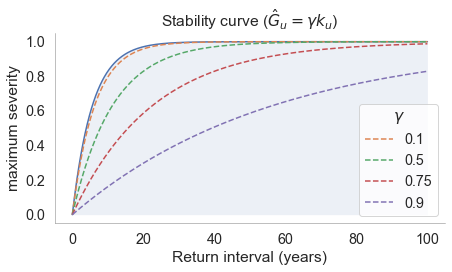

In [6]:

fig, ax = plt.subplots(1, figsize = (7,3.5) )

RIs = np.arange(0, 100, .1)
severities = max_severity_u(p.r_u*p.S**p.beta, RIs)
ax.plot(  RIs,severities )
ax.fill_between(RIs,severities, alpha = 0.1)

for gamma in [0.1, 0.5, 0.75, 0.9]:
    severities = max_severity_u((1-gamma)*p.r_u*p.S**p.beta, RIs)
    ax.plot(RIs, severities , '--', label = gamma)


ax.legend(title = "$\gamma$")
ax.set_ylabel("maximum severity")
ax.set_xlabel("Return interval (years)")
ax.set_title("Stability curve ($\hat G_u = \gamma k_u$)")
fig.savefig(fig_dir + '/stability.png', format='png', dpi=1000, bbox_inches = "tight")


## Double check the stability curve

In [7]:
gamma = 0.5
p = RCSR(params)
severity = max_severity_u((1-gamma)*p.r_u*p.S**p.beta, p.RI)
params["severity"] = severity
p = RCSR(params)
p.run()


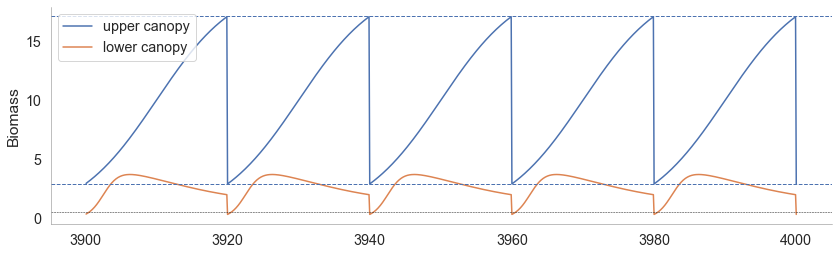

In [8]:
fig, ax = plt.subplots(1, figsize = (14,4) )

to = int(-5*p.RI/p.dt_p)

ax.plot(p.t_p[to:], p.G_u_list[to:], '-', label ="upper canopy")        
ax.plot(p.t_p[to:], p.G_l_list[to:], label = "lower canopy")       
ax.set_ylabel("Biomass")
ax.legend()

G_u_min_a = p.G_u_postfire()
G_u_max_a = G_u_min_a/(1-p.severity)
if G_u_min_a>0:
    plt.axhline(G_u_min_a, ls = "--", lw = 1)
    plt.axhline(G_u_max_a, ls = "--", lw = 1)
    
G_l_postfire = p.G_l_postfire()
if G_l_postfire>0:
    plt.axhline(p.G_l_postfire(),ls =  '--', lw = 0.5,c = 'k')




## Things are slow to converge near the stability boundary

In [9]:
run '/Users/octavia/Dropbox/fire/src_v1/startup.py'

In [10]:
update = {"alpha" : 0.02,                
          "RI" : 20,
          "ti" : 1000,
          "tmax" : 10000,
          "dt_p" : .01
         }
params.update(update)
p = RCSR(update)
print_limits(p)

The minimum return interval with severity = 0.500 is 3.92 years
The maximum severity with RI = 20 years is 0.9709


_Move closer to the severity threshold and reinitialize_

In [11]:
update["severity"] = p.max_severity_u() - 0.02
p = RCSR(update)
diff = diff_from_default(update)
p.run()

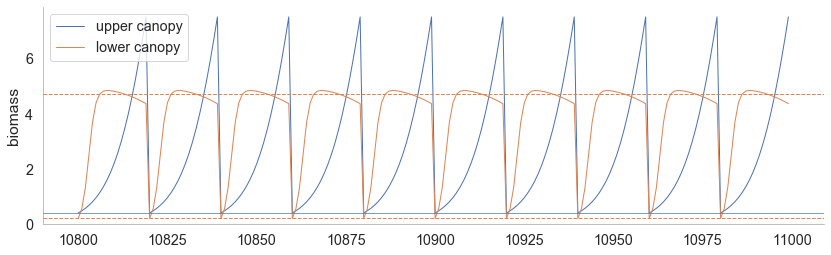

In [12]:
canopy_plot(p, nfire=10)

Text(0.5, 0, 'year')

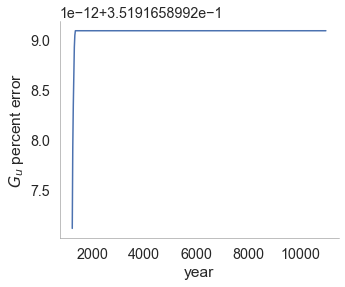

In [13]:
fig, ax = plt.subplots(1, figsize = (5,4))
p.record["G_u_error"] = (p.mean_G_u()- p.record.G_u_mean)/p.mean_G_u()*100

ax.plot(p.record.year[10:], p.record.G_u_error[10:])
ax.set_ylabel("$G_u$ percent error")
ax.set_xlabel("year")
# ???????????

## Upper canopy stability is sensitive to $\beta$

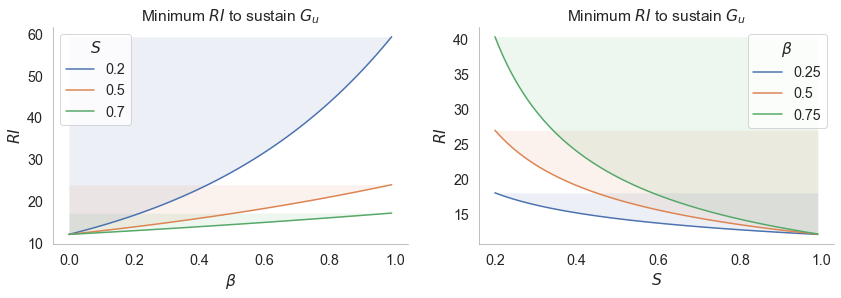

In [15]:
fig, axes = plt.subplots(1,2, figsize = (14, 4))
betas = np.arange(0,1,0.01)
Ss = [0.2, 0.5, 0.7]
ax = axes[0]
for S in Ss:
    r_up = p.r_u*S**betas
    min_RI = -1./r_up*np.log(1-p.severity)

    ax.plot(betas, min_RI, label = S)
    ax.fill_between(betas, min_RI, np.max(min_RI), alpha = 0.1)

ax.set_xlabel(r"$\beta$")
ax.set_title("Minimum $RI$ to sustain $G_u$")
ax.set_ylabel(r"$RI$")

ax.legend(title = "$S$")


ax = axes[1]

S = np.arange(0.2, 1,0.01)
betas = [0.25, 0.5, 0.75]

for beta in betas:
    r_up = p.r_u*S**beta
    min_RI = -1./r_up*np.log(1-p.severity)
    ax.plot(S, min_RI, label = beta)

    plt.fill_between(S, min_RI, np.max(min_RI), alpha = 0.1)

ax.set_xlabel(r"$S$")
ax.set_ylabel("$RI$")
ax.set_title("Minimum $RI$ to sustain $G_u$")
ax.legend(title = r"$\beta$")    
fig.savefig(fig_dir + '/stability_min_RI.png', format='png', dpi=300, bbox_inches = "tight")




## Lower canopy stability is sensitive to $\beta$

In [16]:
def G_l_stability_v_beta(p, update,  betas, ax):
    """
    Plot the stability of the lower canopy as a function of beta
    """
    max_RI = max_RI_l(p.r_l, p.r_u, p.k_u, p.S, betas, p.alpha, p.RI, p.severity)
    max_RI[(p.alpha *p.k_u - p.r_l*p.S**betas) < 0.0] = np.nan
    max_RI[max_RI > 100] = np.nan
    min_RI = min_RI_l(p.r_l, p.S, betas, p.severity)

    ax.plot(betas, max_RI, label = "max $RI$ ")
    ax.plot(betas, min_RI, label = "min $RI$ ")
    ax.fill_between(betas, min_RI, max_RI, alpha = 0.1)

    ax.legend()
    ax.set_title("Lower canopy stability; " + print_dict(update))
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(r"$RI$")

    
    return ax

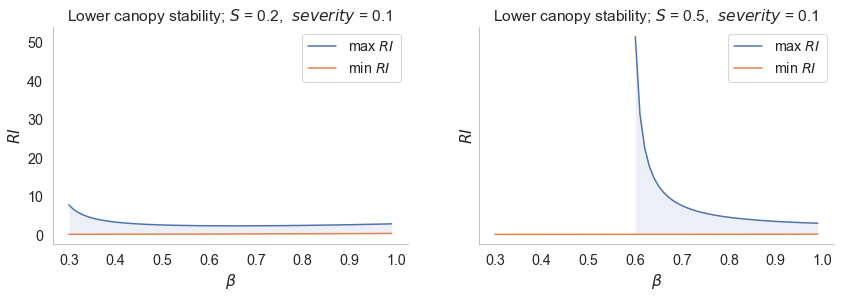

In [19]:
fig, axes = plt.subplots(1,2, sharey = True, figsize = (14, 4))

params = default_params()

betas = np.arange(0.3, 1, 0.01)
ax = axes[0]
update = {"S" : 0.2, "severity" : 0.1}
params.update(update)
p = RCSR(params)

ax = G_l_stability_v_beta(p, update, betas, ax)

ax = axes[1]
update = {"S" : 0.5, "severity" : 0.1}
params.update(update)
p = RCSR(params)

ax = G_l_stability_v_beta(p, update, betas, ax)

fig.savefig(fig_dir + '/G_l_stability_v_beta.png', format='png',
            dpi=300, bbox_inches = "tight")


### Test out intuition here

In [20]:
update = {"S" : 0.5, "beta"  : 1, "RI" : 20}
params.update(update)
p = RCSR(update)

p.run()

## Lower canopy stability is sensitive to $\alpha$

In [21]:
def G_l_stability_v_alpha(p, update,  alphas, ax):
    """
    Plot the stability of the lower canopy as a function of alpha
    """
    max_RI = max_RI_l(p.r_l, p.r_u, p.k_u, p.S, p.beta, alphas, p.RI, p.severity)
    max_RI[(alphas *p.k_u - p.r_l*p.S**p.beta) < 0.0] = np.nan
    max_RI[max_RI > 100] = np.nan
    min_RI = min_RI_l(p.r_l, p.S, p.beta, p.severity)
    
    ax.plot(alphas, max_RI, label = print_dict(update))
    ax.fill_between(alphas, min_RI, max_RI, alpha = 0.1)

    ax.legend()
    ax.set_title("Lower canopy stability")
    ax.set_xlabel(r"$\alpha$")
    ax.set_ylabel(r"$RI$")

    
    return ax

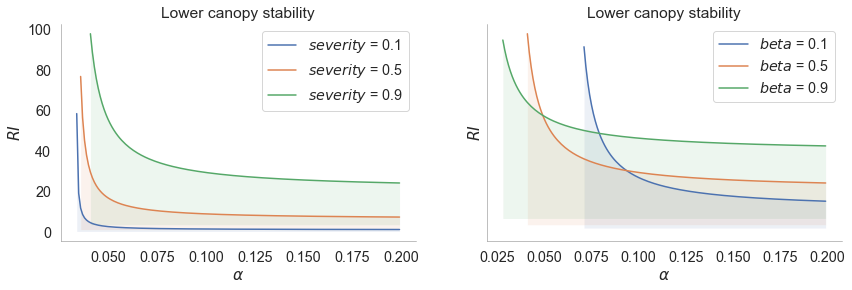

In [24]:
fig, axes = plt.subplots(1,2, sharey = True, figsize = (14, 4))

alphas = np.arange(0, 0.2, 0.001)
params = default_params()
params.update({"S" : 0.2})
ax = axes[0]
severities = [0.1, 0.5, 0.9]
for severity in severities:
    update = {"severity" : severity}
    params.update(update)
    p = RCSR(params)
    ax = G_l_stability_v_alpha(p, update, alphas, ax)

ax = axes[1]
betas = [0.1, 0.5, 0.9]
for beta in betas:
    update = {"beta" : beta}
    params.update(update)
    p = RCSR(params)
    ax = G_l_stability_v_alpha(p, update, alphas, ax)

fig.savefig(fig_dir + '/G_l_stability_v_alpha.png', format='png',
            dpi=300, bbox_inches = "tight")



## Lower canopy stability is sensitive to $r_l$

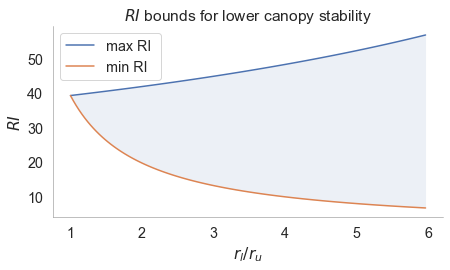

In [27]:
fig, axes = plt.subplots(1, sharey = True, figsize = (7, 3.5))

r_l = np.arange(0.25, 1.5, 0.01)

max_RI = max_RI_l(r_l, p.r_u, p.k_u, p.S, beta, p.alpha, p.RI, p.severity)
max_RI[(p.alpha *p.k_u - r_l*p.S**beta) < 0.0] = np.nan

min_RI = min_RI_l(r_l, p.S, beta, p.severity)

plt.plot(r_l/p.r_u, max_RI, label = "max RI ")
plt.plot(r_l/p.r_u, min_RI, label = "min RI ")
plt.fill_between(r_l/p.r_u, min_RI, max_RI, alpha = 0.1)

plt.legend()
plt.xlabel(r"$r_l / r_u$")
plt.ylabel(r"$RI$")

plt.title("$RI$ bounds for lower canopy stability")

fig.savefig(fig_dir + '/G_l_stability_v_rl.png', format='png',
            dpi=300, bbox_inches = "tight")



### There is a range of return intervals where G_l persists, even though its equilbrium value would be zero

Text(0, 0.5, 'normalized mean biomass')

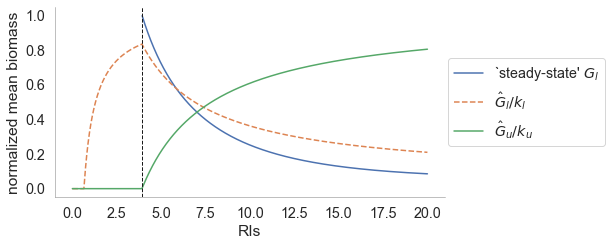

In [29]:
params = default_params()
p = RCSR(params)
RIs = np.arange(0, 20, 0.01)

# mean G_u
G_u_mean = mean_G_u( p.r_u, p.k_u, p.S, p.beta, RIs, p.severity)
# mean G_l
G_l_mean = mean_G_l(p.r_l, p.r_u, p.k_l, p.k_u, p.S, p.beta, p.alpha, RIs, p.severity)

#  G_l_eq (in equilibrium with G_u pre-fire)
G_l_eq = G_l_equil(p.r_l, p.r_u, p.k_l,  p.k_u, p.S, p.beta, p.alpha, RIs, p.severity)
G_l_eq[G_u_mean == 0] = np.nan

fig, ax = plt.subplots(1, sharey = True, figsize = (7, 3.5))

RI_u_min = min_RI_u(p.r_u, p.S, p.beta, p.severity)

ax.plot(RIs, G_l_eq/p.k_l, label = "`steady-state' $G_l$")
ax.plot(RIs, G_l_mean/p.k_l, '--', label = "$\hat G_l/k_l$")
ax.plot(RIs, G_u_mean/p.k_u, label = "$\hat G_u/k_u$")

ax.legend(loc='center left', bbox_to_anchor=(0.99, 0.5))
plt.axvline(RI_u_min, c = 'k', lw = 1, ls = '--')
ax.set_xlabel("RIs")
ax.set_ylabel("normalized mean biomass")

## Recovery time for the upper biomass to return to $\gamma k_u$

$$ t = \frac{1}{r} \log\bigg( \frac{\gamma  \phi_S}{(1-\gamma)(1 - \phi_S - e^ {-r\omega})}\bigg)$$

where $\xi $ is the return interval.


Note that the denominator, $1 - \phi_S - e^{-r\omega}$ must be greater than zero.
This is the same as the 'canopy collapse' threshold for $G_u > 0$


In [31]:
params = default_params()
update = {
          "S" : 0.3,
          "alpha" : 0.02,
          "beta" : 0.5,          
          "RI" : 20,
          "severity" : 0.9,
         }
params.update(update)

p = RCSR(update)
print_limits(p)

The minimum return interval with severity = 0.900 is 16.82 years
The maximum severity with RI = 20 years is 0.9353


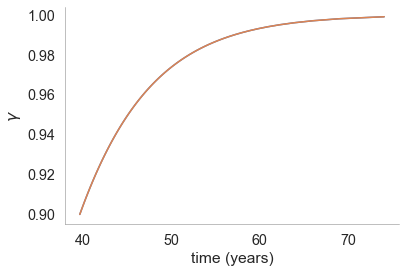

In [32]:
G_u_min = p.G_u_postfire()
r_up = p.r_u*p.S**p.beta
gamma = np.arange(.9, 1., .001)

plt.plot(1/r_up*np.log(gamma/(1-gamma)*(p.k_u - G_u_min)/G_u_min), gamma)
plt.plot(1/r_up*np.log(gamma/(1-gamma)*p.severity/(1-p.severity - np.exp(-r_up*p.RI))), gamma)
plt.xlabel("time (years)")
plt.ylabel(r"$\gamma$");



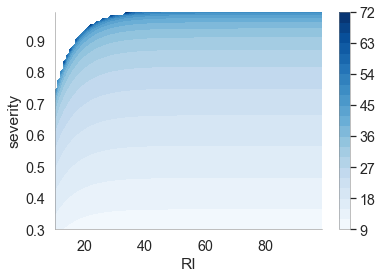

In [33]:

def equil_time(r, gamma, severity,  freq):
    """
    Compute the time after fire until  G_u = gamma*k_u
    """
    return 1/r*np.log(gamma/(1-gamma)*severity/(1-severity - np.exp(-r*freq)))

freqs = np.arange(10, 100)
severities = np.arange(0.3, 1, .01)
freqs, severities = np.meshgrid(freqs, severities)
plt.contourf( freqs, severities, equil_time(r_up, 0.9, severities,  freqs),
             20, cmap = "Blues")
plt.colorbar()

plt.xlabel("RI")
plt.ylabel(r"severity");

## How close to $k_u$ does $G_u$ get?

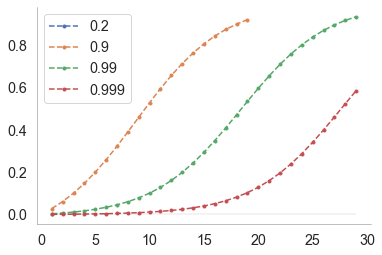

In [34]:
def fix_G_u_max(r_u, S, beta, RI, gamma ):
    """
    Given return time RI and plant parameters,
    finds the severity for which G_u_max = k_u*gamma
    """
    
    r_up = r_u*S**beta
    C =  1./gamma -1
    phi_S = C*(1- np.exp(-r_u*RI))/(C + np.exp(-r_u*RI))

    
    y = 1- phi_S - np.exp(-r_up*RI) # stability threshold
 
    
    if np.size(y) == 1:
        if y < 0:
            phi_S = np.nan
            
    else:
        phi_S[y<0] = np.nan
    
    return phi_S
        

RIs = np.arange(1,30)
gamma = 0.2
plt.plot(RIs,fix_G_u_max(p.r_u, p.S, p.beta, RIs, gamma ),".--", label = gamma)
gamma = 0.9
plt.plot(RIs,fix_G_u_max(p.r_u, p.S, p.beta, RIs, gamma ),".--", label = gamma)
gamma = 0.99
plt.plot(RIs,fix_G_u_max(p.r_u, p.S, p.beta, RIs, gamma ),".--", label = gamma)

gamma = 0.999
plt.plot(RIs,fix_G_u_max(p.r_u, p.S, p.beta, RIs, gamma ),".--", label = gamma)


plt.plot(RIs,RIs*0, "k", lw = .1)
plt.legend()

